<h1 align='center'>Tutorial: Implementing Layer-Wise Relevance Propagation</h1>
<br>
    <p><em>
    first version: Jul 14, 2016<br>
    last update: Sep 17, 2019
    </em></p>
    <p>This tutorial explains how to implement layer-wise relevance propagation (LRP) easily and efficiently, as described in the overview paper:    
    <blockquote style='background-color:#EEEEEE; padding: 3px; border: 1px dashed #999999'>
    G. Montavon, A. Binder, S. Lapuschkin, W. Samek, K.-R. Müller<br><a href=\"https://doi.org/10.1007/978-3-030-28954-6_10\">Layer-wise Relevance Propagation: An Overview</a><br><font color=\"#008800\">in Explainable AI: Interpreting, Explaining and Visualizing Deep Learning, Springer LNCS, vol. 11700,
    2019</font>
    </blockquote>
    We consider two models: (1) a simple plain deep rectifier network trained on the MNIST handwritten digits data, (2) the VGG-16 network trained on ImageNet and applicable to general image classification.</p>
    <p><em>Note:</em> If you are instead looking for ready to use software, have a look at the <a href=\"http://www.heatmapping.org/index.html#software\">software section</a> of this website. If you want to try relevance propagation without installing software, check our <a href=\"http://www.heatmapping.org/index.html#demos\">interactive demos</a>. For the original paper on LRP, see instead:</p>
    <blockquote style='background-color:#EEEEEE; padding: 3px; border: 1px dashed #999999'>
    S. Bach, A. Binder, G. Montavon, F. Klauschen, K.-R. Müller, W. Samek<br><a href=\"https://doi.org/10.1371/journal.pone.0130140\">On pixel-wise explanations for non-linear classifier decisions by layer-wise relevance propagation</a><br><font color=\"#008800\">PloS ONE 10 (7), e0130140,
    2015</font>
    </blockquote>

<h2>1 &nbsp; Numpy Implementation for a Fully-Connected Network</h2>

<p>We first load 12 examplary MNIST test digits.</p>

In [ ]:
!git clone https://github.com/songhuadan/explain-transformers.git

import os
os.chdir(f'./explain-transformers')

Mounted at /content/drive


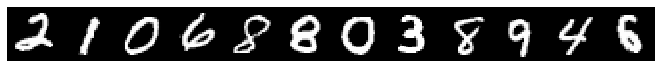

In [ ]:
import utils
X,T = utils.loaddata()
%matplotlib inline
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

In [ ]:
a1 = X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28)

In [ ]:
X.shape

(12, 784)

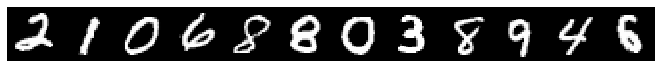

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(9,0.75))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.axis('off')
plt.imshow(a1, interpolation='nearest', cmap='gray')
plt.show()

Each digit is stored as a 784-dimensional vector of pixel values, where "-1.0" corresponds to black and "+1.0" corresponds to white. 

<h3>1.1 &nbsp; Predicting the class of MNIST digits</h3>

<p>These digits are fed to a fully connected neural network with layer sizes 784-300-100-10 with ReLU activations for each hidden layer. The architecture is depicted in the figure below.</p>
<center>
<img src="mlp.png" width=350>
</center>
<p>The network we consider achieves an error of 1.6% which is a typical performance for a neural network without particular structure or regularization. The function <code>utils.loadparams()</code> retrieves its parameters for us.</p>

In [ ]:
W,B = utils.loadparams()
L = len(W)

<p>From these parameters, the forward pass can be computed as a sequence of matrix multiplications and nonlinearities.</p>

In [ ]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])

Note that this code has added an additional top-layer ReLU activation compared to the original neural network. This however doesn't affect computations when looking at positive output scores. The top layer activations are scores measuring the evidence the network has found for each class. In the following, we show the first three digits and the scores produced for each class at the output:

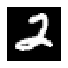

[0] 0.0  [1] 3.6  [2] 49.1  [3] 8.9  [4] 0.0  [5] 0.0  [6] 0.0  [7] 1.4  [8] 1.6  [9] 0.0


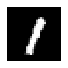

[0] 0.0  [1] 27.0  [2] 0.0  [3] 0.0  [4] 5.3  [5] 0.0  [6] 0.0  [7] 13.0  [8] 8.1  [9] 2.3


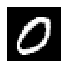

[0] 49.1  [1] 0.0  [2] 10.6  [3] 0.0  [4] 0.0  [5] 0.2  [6] 0.0  [7] 3.0  [8] 0.0  [9] 9.2


In [ ]:
for i in range(3):
    utils.digit(X[i].reshape(28,28),0.75,0.75)
    p = A[L][i]
    print("  ".join(['[%1d] %.1f'%(d,p[d]) for d in range(10)]))

<p>As expected, the highest score systematically corresponds to the correct digit.</p>

<h3>1.2 &nbsp; Explaining the predictions with LRP</h3>

<p>We now implement the layer-wise relevance propagation (LRP) procedure from the top to the bottom of the network. As a first step, we create a list to store relevance scores at each layer. The top layer relevance scores are set to the top-layer activations, which we multiply by a label indicator in order to retain only the evidence for the actual class.</p>

In [ ]:
R = [None]*L + [A[L]*(T[:,None]==numpy.arange(10))]

In [ ]:
R

[None,
 None,
 None,
 array([[ 0.        ,  0.        , 49.09544781,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , 26.99117571,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [49.08468754,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , 41.87610684,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , 30.96404237,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , 30.36133447,  0.        ],
        [66.65911419,  0.        ,  0.        ,  0.        ,  0.        ,
          0

<p> The LRP-0, LRP-ϵ, and LRP-γ rules described in the <a href="https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10">LRP overview paper</a> (Section 10.2.1) for propagating relevance on the lower layers are special cases of the more general propagation rule</p>

<img src="http://latex.codecogs.com/svg.latex?R_j = \sum_k \frac{a_j \rho(w_{jk})}{\epsilon + \sum_{0,j} a_j \rho(w_{jk})} R_k">

<p>(cf. Section 10.2.2), where ρ is a function that transform the weights, and ϵ is a small positive increment. We define below two helper functions that perform the weight transformation and the incrementation. In practice, we would like to apply different rules at different layers (cf. Section 10.3). Therefore, we also give the layer index "<code>l</code>" as argument to these functions.</p>

In [ ]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

<p>In particular, these functions and the layer they receive as a parameter let us reduce the general rule to LRP-0 for the top-layer, to LRP-ϵ with ϵ = 0.1std for the layer just below, and to LRP-γ with γ=0.1 for the layer before. We now come to the practical implementation of this general rule. It can be decomposed as a sequence of four computations:</p>

<p>
<img src="http://latex.codecogs.com/svg.latex?
\begin{align*}
\forall_k:~z_k = {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall_k:~s_k = R_k / z_k \qquad & (\text{step }2)\\
\forall_j:~c_j = {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall_j:~R_j = a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
">
</p>

<p>The layer-wise relevance propagation procedure then consists of iterating over the layers in reverse order, starting from the top layer towards the first layers, and at each layer, applying this sequence of computations.</p>

In [ ]:
for l in range(1,L)[::-1]:

    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

<p>Note that the loop above stops one layer before reaching the pixels. To propagate relevance scores until the pixels, we need to apply an alternate propagation rule that properly handles pixel values received as input (cf. Section 10.3.2). In particular, we apply for this layer the zB-rule given by:</p>

<img src="http://latex.codecogs.com/svg.latex?R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j">

<p>In this rule, <i>l<sub>i</sub></i> and <i>h<sub>i</sub></i> are the lower and upper bounds of pixel values, i.e. "-1" and "+1", and (·)<sup>+</sup> and (·)<sup>–</sup> are shortcut notations for max(0,·) and min(0,·). The zB-rule can again be implemented with a four-step procedure similar to the one used in the layers above. Here, we need to create two copies of the weights, and also create arrays of pixel values set to <i>l<sub>i</sub></i> and <i>h<sub>i</sub></i> respectively:</p>

In [ ]:
w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

<p>We have now reached the bottom layer. The obtained pixel-wise relevance scores can be rendered as a heatmap.</p>

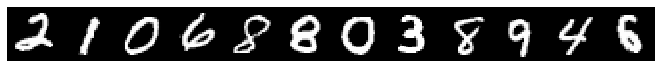

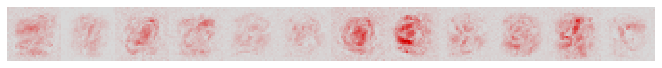

In [ ]:
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
utils.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

Relevant pixels are highlighted in red. Pixels that contribute negatively to the prediction, if any, are shown in blue. On most digits, we find that the digit itself is highlighted, as well as some parts of the background. For example, we observe two red horizontal bars next to the digit "3", highlighting the fact that if those pixels would be different, the digit 3 would likely turn into a "8". Same for the vertical bar above the digit "4" that supports the class "4" instead of the class "9".

<h2>2 &nbsp; PyTorch Implementation for the VGG-16 Network</h2>

<p>In the example above, LRP rules could be easily expressed in terms of matrix-vector operations. In practice, state-of-the-art neural networks such as VGG-16 make use of more complex layers such as convolutions and pooling. In this case, LRP rules are more conveniently implemented by casting the operations of the four-step procedure above as <em>forward</em> and <em>gradient</em> evaluations on these layers. These operations are readily available in neural network frameworks such as PyTorch and TensorFlow, and can therefore be reused for the purpose of implementing LRP. Here, we take the VGG-16 pretrained network for image classification. For this network, we consider the task of explaining the evidence for the class "castle" it has found in the following image:</p>
<center>
<img src="castle.jpg" width=224 style='margin: 0.5em'>
</center>
<p>The image is first loaded in the notebook.</p>

In [ ]:
import numpy, utils

In [ ]:
import cv2
img = numpy.array(cv2.imread('elephant and zebra.jpg'))[...,::-1]/255.0

<p>It is then converted to a torch tensor of appropriate dimensions and normalized to be given as input to the VGG-16 network.</p>

In [ ]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

<p>The VGG-16 network is then loaded and its top-level dense layers are converted into equivalent 1x1 convolutions.</p>

In [ ]:
import torchvision

model_1 = torchvision.models.vgg16(pretrained=True); model.eval()
# model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1'); model.eval()
layers_1 = list(model_1._modules['features']) + utils.toconv(list(model_1._modules['classifier']))
# layers = list(model._modules['encoder']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
list(model._modules['encoder']._modules['layers'])

[EncoderBlock(
   (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   (self_attention): MultiheadAttention(
     (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   )
   (dropout): Dropout(p=0.0, inplace=False)
   (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   (mlp): MLPBlock(
     (0): Linear(in_features=768, out_features=3072, bias=True)
     (1): GELU(approximate=none)
     (2): Dropout(p=0.0, inplace=False)
     (3): Linear(in_features=3072, out_features=768, bias=True)
     (4): Dropout(p=0.0, inplace=False)
   )
 ), EncoderBlock(
   (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   (self_attention): MultiheadAttention(
     (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   )
   (dropout): Dropout(p=0.0, inplace=False)
   (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   (mlp): MLPBlock(
     (0): Linear(in_features=768, out_features=3072

In [ ]:
layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)]

In [ ]:
len(layers)

152

In [ ]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [ ]:
L

152

<h3>2.1 &nbsp; Predicting the class of an image</h3>

<p>The input can then be propagated in the network and the activations at each layer are collected:</p>

In [ ]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

<p>Activations in the top layer are the scores the neural network predicts for each class. We show below the 10 classes with highest score:</p>

In [ ]:
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              tusker (101):  7.134
African elephant, Lo (386):  6.905
Indian elephant, Ele (385):  6.612
               zebra (340):  6.542
             warthog (343):  6.192
Arabian camel, drome (354):  5.185
       hyena, hyaena (276):  5.129
lion, king of beasts (291):  4.886
wild boar, boar, Sus (342):  4.801
          hartebeest (351):  4.792


<p>We observe that the neuron castle (index 483) has the highest score. This is expected due to the presence of a castle in the image. Note that other building-related classes are also assigned a high score, as well as classes corresponding to other objects present in the image (e.g. street sign and traffic light).</p>

<h3>2.2 &nbsp; Explaining the prediction with LRP</h3>

<p>The following code iterates from the top layer to the first layer in reverse order and applies propagation rules at each layer. Top-layer activations are first multiplied by the mask to retain only the predicted evidence for the class "castle".</p>

In [ ]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==ind[3]).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]

<p>This evidence can then be propagated backward in the network by applying propagation rules at each layer.</p>

<p><b>Convolution layers:</b> Observing that convolutions are special types of linear layers, we can use the same propagation rules as in the MNIST example, and a similar four-step procedure for applying these rules. Steps 2 and 4 are simple element-wise computations. Step 1 can be implemented as a forward computation in the layer, where we have preliminary transformed the layer parameters, and where we apply the increment function afterwards. As shown in the LRP overview paper, Step 3 can instead be computed as a gradient in the space of input activations:</p>

<img src="http://latex.codecogs.com/svg.latex?c_j = \big[\nabla~\big({\textstyle \sum_k}~z_k(\boldsymbol{a}) \cdot s_k\big)\big]_j">

<p>where <i>s<sub>k</sub></i> is treated as constant.</p>

<p><b>Pooling layers:</b> It is suggested in Section 10.3.2 of the paper to treat max-pooling layers as average pooling layers in the backward pass. Observing that average pooling is also a special linear layer, the same propagation rules as for the convolutional layers become applicable.</p>

<p>In the following code, we iterate the propagation procedure from the top-layer towards the lower layers. Whenever we meet a max-pooling layer, we convert it into an average pooling layer. The function <code>rho</code> and <code>incr</code> are set differently at each layer, following the strategy of Section 10.3.</p>

In [ ]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]

As each layer is composed of a collection of two-dimensional feature maps, relevance scores at each layer can be visualized as a two-dimensional map. Here, relevance scores are pooled over all feature maps at a given layer. The two-dimensional maps are shown for a selection of VGG-16 layers.

In [ ]:
from IPython.display import Image 

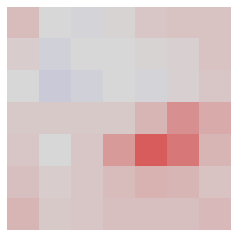

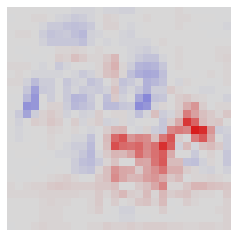

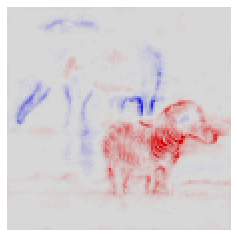

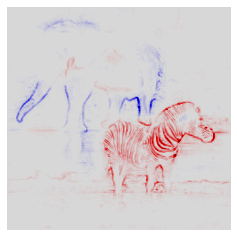

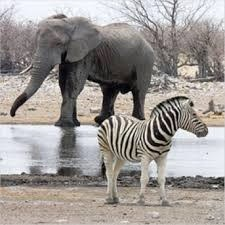

In [ ]:
for i,l in enumerate([31,21,7,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),3.1,3.1)

Image('elephant and zebra.jpg')

<p>We observe that the explanation becomes increasingly resolved spatially. Note that, like for the MNIST example, we have stopped the propagation procedure one layer before the pixels because the rule we have used is not applicable to pixel layers. Like for the MNIST case, we need ot apply the pixel-specific zB-rule for this last layer. This rule can again be implemented in terms of forward passes and gradient computations.</p>

In [ ]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

The relevance scores obtained in the pixel layer can now be summed over the RGB channels to indicate actual pixel-wise contributions.

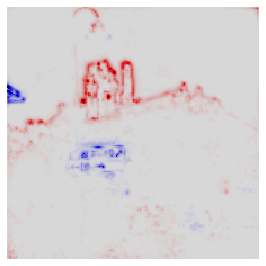

In [ ]:
utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

We observe that the heatmap highlights the outline of the castle as evidence for the corresponding class. Some elements such as the traffic sign or the roof on the left are seen as having a negative effect on the neuron "castle" and are consequently highlighted in blue.